## Open Sprayer Classification

Within this notebook, we will be building a classifier to classify between [Dock weeds (Rumex)](https://en.wikipedia.org/wiki/Rumex) and everything else (grass, dirt, gravel, other smaller plant species found in farm fields). The purpose of this notebook, is to contribute to the **Open Sprayer** project, which has the goal of building an autonomous, open source drone that weeds farm fields. For more information, see the [Open Sprayer website](http://www.opensprayer.com/). 

To build this classifier, we follow the typical Fastai approach to classifying images. To see the basis of where the majority of this code is based upon, see the [lesson 1 from the 2018 Part One MOOC](http://forums.fast.ai/t/wiki-lesson-1/9398). Most of the minutae of this notebook, and the reasoning behind certain steps are explained therein.

We will conduct a simple exploratory data analysis, and then begin fitting our pretrained convolutional neural net (via transfer learning).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = '/home/paperspace/data/open-sprayer-images/docknet/'
os.makedirs('/home/paperspace/data/open-sprayer-images/docknet/models', exist_ok=True)
os.makedirs('/home/paperspace/data/open-sprayer-images/docknet/tmp', exist_ok=True)

## Exploring the data

In [4]:
import os, os.path
# find the number of weed pictures
print('__Training Data figures__\n')
print('Number of weed pictures: ', len([name for name in os.listdir(f'{PATH}/train/docks')]))

# find the number of grass pictures
print('Number of non-weed pictures: ', len([name for name in os.listdir(f'{PATH}/train/notdocks')]))


__Training Data figures__

Number of weed pictures:  405
Number of non-weed pictures:  1656


We immediately see an imbalance of approximately four to one. We can then consider upsampling the training data. This is discussed at the end of the notebook. Let's take a look at the validation set provided

In [5]:
print('__Validation Data figures__\n')
print('Number of weed pictures: ', len([name for name in os.listdir(f'{PATH}/valid/docks')]))
# find the number of grass pictures
print('Number of non-weed pictures: ', len([name for name in os.listdir(f'{PATH}/valid/notdocks')]))

__Validation Data figures__

Number of weed pictures:  21
Number of non-weed pictures:  49


This is far too few in the validation set. Usually we split the data 60/40, up to 90/10, training and validation set portions, respectively. Let us reconfigure the data to an 80/20 split.

In [6]:
# Gather all notdock into one list, and all dock into one list

dock_list = [os.path.join(f'{PATH}train/docks', name) for name in os.listdir(f'{PATH}train/docks')] + \
    [os.path.join(f'{PATH}valid/docks', name) for name in os.listdir(f'{PATH}valid/docks')]

notdock_list = [os.path.join(f'{PATH}train/notdocks', name) for name in os.listdir(f'{PATH}train/notdocks')] + \
    [os.path.join(f'{PATH}valid/notdocks', name) for name in os.listdir(f'{PATH}valid/notdocks')]

print('Total dock pictures: ', len(dock_list))
print('Total notdock pictures: ', len(notdock_list))

Total dock pictures:  426
Total notdock pictures:  1705


Randomly split the data to the 80/20 portions; training and validation sets. (Note we set a seed, so that anyone using this notebook in future, can work with the same datasets.)

In [7]:
import random
random.seed(42)
dock_total = len(dock_list)
dock_train_num = int(0.8 * dock_total)
dock_valid_num = dock_total - dock_train_num

# randomly selecting training dock images
dock_training_list = random.sample(dock_list, dock_train_num)
# putting the left overs into the validation set
dock_validation_list = [name for name in dock_list if name not in dock_training_list]


notdock_total = len(notdock_list)
notdock_train_num = int(0.8 * notdock_total)

notdock_valid_num = notdock_total - notdock_train_num
notdock_training_list = random.sample(notdock_list, notdock_train_num)
# putting the left overs into the validation set
notdock_validation_list = [name for name in notdock_list if name not in notdock_training_list]

In [8]:
# Now copy images to new folders
new_folder_names = [f'{PATH}train_new/docks',f'{PATH}train_new/notdocks',
                    f'{PATH}valid_new/docks', f'{PATH}valid_new/notdocks']
for name in new_folder_names:
#     recursively make the required directories.
    os.makedirs(name)

In [9]:
from shutil import copy2
pairs = [(f'{PATH}train_new/docks', dock_training_list), (f'{PATH}train_new/notdocks', notdock_training_list),
         (f'{PATH}valid_new/docks', dock_validation_list), (f'{PATH}valid_new/notdocks', notdock_validation_list)]

for tup_pair in pairs:
    filename_list = tup_pair[-1]
    destination = tup_pair[0]
    for fname in filename_list:
        copy2(fname, destination)

## Fitting Data

Now that we have the data squared away, we can begin training our neural net on it. We will follow the paradigm set out in the Fastai MOOC. Firstly, we take a 'simple' architecture, in our case Resnet34, which has been pretrained on the ImageNet data set. We will then remove the final layer (classifying 1000 objects), to a two neuron output representing our classes: docks, notdocks. We will then find the appropriate learning rate, and from there perform cyclical learning, as well as increasing the image size, to boost the performance of our classifier.

In [10]:
from fastai.model import * 
from sklearn.metrics import roc_auc_score, auc

# loading the appropriate architecture and weights
f_model = resnet34


For this dataset, we will do some basic transforms to the images, and also allow the image to be inverted both top to bottom, and side on.

In [11]:
def get_data(sz, bs):
    aug_tfms = transforms_basic + [RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=aug_tfms, max_zoom=2.0)
    return ImageClassifierData.from_paths(PATH, trn_name='train_new', val_name='valid_new', bs=bs, tfms=tfms)

Here, we start off the training process where all images have been resized to 64x64 (the original ImageNet images were of 299x299 sizes). We start off with smaller images, and increasing their sizes step by step to reduce overfitting of the model

In [12]:
sz = 64
batch_size = 64

In [13]:
data = get_data(sz, batch_size)

In [14]:
learn = ConvLearner.pretrained(f_model, data)

## Finding optimal learning rate

 89%|████████▉ | 24/27 [00:04<00:00,  5.68it/s, loss=3.92] 
Time taken:  4.7168755531311035  seconds                  


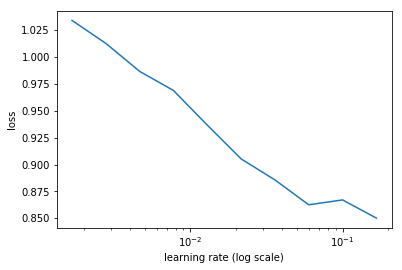

In [15]:
import time
start_t = time.time()
lrf=learn.lr_find()
learn.sched.plot()

del_t = time.time() - start_t
print('Time taken: ', del_t, ' seconds')

Normally whilst searching for the appropriate learning rate, we see a mirrored logistic curve, and select a learning rate just before the plateau of the curve. Here, we see more of a linear function that could possibly be plateauing. So we make our best guess at a good learning rate.

In [16]:
lr = 0.05

## Training the model

In [17]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.528588   0.28421    0.908665  
    1      0.472276   0.317575   0.901639                  
    2      0.430853   0.263802   0.918033                  
    3      0.409255   0.273115   0.911007                  
    4      0.406809   0.262176   0.908665                  
    5      0.375493   0.255527   0.911007                  
    6      0.34763    0.247938   0.915691                  
    7      0.363932   0.26682    0.908665                  
    8      0.386173   0.350732   0.899297                  
    9      0.392166   0.254927   0.925059                  
    10     0.375275   0.226298   0.913349                  
    11     0.34737    0.241091   0.9274                    
    12     0.333842   0.239714   0.920375                  
    13     0.325779   0.231387   0.922717                  
    14     0.31495    0.232783   0.922717                  



[array([0.23278]), 0.9227166276346604]

We have achieved a decent accuracy on our first go, but there appears to be some overfitting happening for which we should be cautious of.

Next, we allow different learning rates to be assigned to different groups of layers in our achitecture. This is usually where one can see the greatest improvement in the accuracy.

In [18]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
result = learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
print(result)

epoch      trn_loss   val_loss   accuracy                  
    0      0.374443   0.209392   0.920375  
    1      0.366586   0.260588   0.922717                  
    2      0.338494   0.194887   0.932084                  
    3      0.321823   0.227146   0.920375                  
    4      0.31084    0.191174   0.93911                   
    5      0.28897    0.176254   0.953162                  
    6      0.273595   0.170793   0.946136                  
    7      0.276532   0.191255   0.946136                  
    8      0.279252   0.164426   0.957845                  
    9      0.269709   0.176325   0.948478                  
    10     0.262363   0.182073   0.943794                  
    11     0.232816   0.16808    0.953162                  
    12     0.220753   0.16878    0.955504                  
    13     0.215628   0.163823   0.95082                   
    14     0.208063   0.162755   0.953162                  

[array([0.16276]), 0.9531615925058547]


In [19]:
learn.save('Resnet34_Size_64')

## Increasing size to 128

In [20]:
sz = 128
learn.set_data(get_data(sz, batch_size))

epoch      trn_loss   val_loss   accuracy                  
    0      0.52969    126.098526 0.393443  



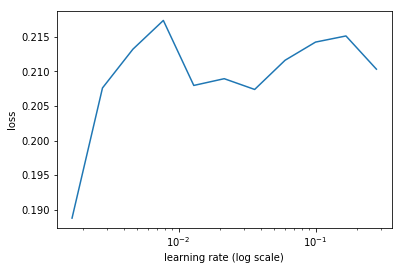

In [21]:
lrf = learn.lr_find()
learn.sched.plot()

We seem to have overshot the 'sweet spot' learning rate before curve rises due to overfitting. Therefore, we opt for a low learning rate.

In [22]:
lr = 0.001
learn.freeze()
result = learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
print(result)

epoch      trn_loss   val_loss   accuracy                  
    0      0.221571   0.142478   0.955504  
    1      0.213289   0.138256   0.955504                  
    2      0.227861   0.137613   0.957845                  
    3      0.222909   0.139244   0.957845                  
    4      0.222564   0.138454   0.957845                  
    5      0.211512   0.138574   0.957845                  
    6      0.207911   0.138698   0.957845                  

[array([0.1387]), 0.9578454332552693]


In [23]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
result = learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
print(result)

epoch      trn_loss   val_loss   accuracy                  
    0      0.248854   0.133364   0.962529  
    1      0.240387   0.134713   0.962529                  
    2      0.235305   0.133143   0.960187                  
    3      0.228285   0.132742   0.962529                  
    4      0.231349   0.131933   0.962529                  
    5      0.233035   0.132013   0.960187                  
    6      0.228279   0.132042   0.960187                  
    7      0.222273   0.13296    0.960187                  
    8      0.21258    0.133138   0.962529                  
    9      0.204168   0.130349   0.960187                  
    10     0.204662   0.132108   0.960187                  
    11     0.205462   0.132423   0.957845                  
    12     0.206184   0.130609   0.960187                  
    13     0.207665   0.132547   0.957845                  
    14     0.201481   0.13272    0.957845                  

[array([0.13272]), 0.9578454332552693]


Here we can definitely see signs of overfitting, we should have reduced the number of epochs run, but we have marginally increased the accuracy.

In [24]:
learn.save('Resnet34_Size_128')

## Increasing size to 256

In [25]:
sz = 256
learn.set_data(get_data(sz, batch_size))

epoch      trn_loss   val_loss   accuracy                  
    0      0.549195   11.551887  0.751756  



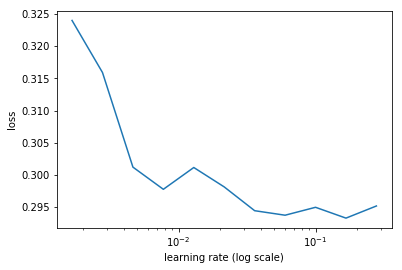

In [26]:
lrf = learn.lr_find()
learn.sched.plot()

In [27]:
lr = 0.005
learn.freeze()
result = learn.fit(lr, 4, cycle_len=1, cycle_mult=2)
print(result)

epoch      trn_loss   val_loss   accuracy                  
    0      0.247127   0.194377   0.929742  
    1      0.265403   0.183652   0.934426                  
    2      0.275122   0.184157   0.936768                  
    3      0.261879   0.177268   0.932084                  
    4      0.248416   0.176937   0.932084                  
    5      0.258563   0.176478   0.932084                  
    6      0.264862   0.176802   0.936768                  
    7      0.277585   0.188263   0.936768                  
    8      0.274993   0.175737   0.934426                  
    9      0.268447   0.176544   0.934426                  
    10     0.264055   0.173953   0.932084                  
    11     0.263862   0.177929   0.932084                  
    12     0.258741   0.173842   0.932084                  
    13     0.260221   0.172725   0.932084                  
    14     0.254207   0.172865   0.932084                  

[array([0.17287]), 0.9320843080167748]


In [28]:
lrs = np.array([lr/9, lr/3, lr])
learn.unfreeze()
result = learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)
print(result)

epoch      trn_loss   val_loss   accuracy                  
    0      0.268859   0.166367   0.941452  
    1      0.254751   0.146434   0.957845                  
    2      0.246353   0.153524   0.95082                   
    3      0.24316    0.139494   0.953162                  
    4      0.229659   0.137821   0.955504                  
    5      0.22605    0.136497   0.955504                  
    6      0.219512   0.135281   0.955504                  
    7      0.218944   0.136357   0.955504                  
    8      0.212216   0.132634   0.953162                  
    9      0.211802   0.124886   0.962529                  
    10     0.199383   0.124049   0.962529                  
    11     0.206202   0.120067   0.962529                  
    12     0.204494   0.119208   0.967213                  
    13     0.204041   0.118981   0.967213                  
    14     0.206852   0.118287   0.962529                  

[array([0.11829]), 0.9625292728879692]


In [29]:
learn.save('Resnet34_Size_256')

In [ ]:
We have increased accuracy by a decent amount since the first run. Let us now analyze the results.

## Analyzing Results

In [30]:
print(data.classes, ' = [0, 1]\n')
log_preds = learn.predict()
log_preds.shape
print(log_preds[:10])

['docks', 'notdocks']  = [0, 1]

[[ -2.11594  -0.12842]
 [ -0.00264  -5.9399 ]
 [ -0.02764  -3.60245]
 [ -0.      -14.39078]
 [ -0.      -12.42454]
 [ -0.11779  -2.19716]
 [ -2.72475  -0.06781]
 [ -0.00004 -10.16665]
 [ -3.63424  -0.02676]
 [  0.      -20.01055]]


As we see above through the ten pairs of predictions are the log probabilities of belonging to a specific class. We need to convert these predictions back to binary format to then assess the accuracy of the algorithm through the ScikitLearn API.

In [31]:
# argmax function takes which index has the higher value, or the highest log probability for a given class.
# A simple method for changing the probability pairs to binary predictions
preds = np.argmax(log_preds, axis=1)  
print(preds[:10])
# Finding actual predicted probabilities.
probs = np.exp(log_preds[:,1])

[1 0 0 0 0 0 1 0 1 0]


To qualitatively assess the performance of our algorithm, we need to view the pictures with their predicted class probabilities. Hopefully, here we can get a clue on where our algorithm might be failing. The code below is taken verbatim from the fastai repo on github.

In [32]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

A few ranodmly selected pictures correctly classified


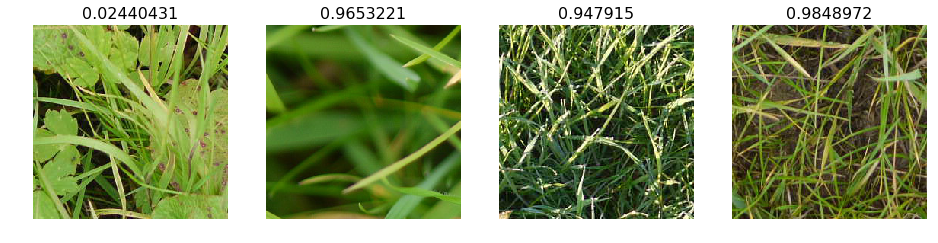

In [33]:
plot_val_with_title(rand_by_correct(True), "A few ranodmly selected pictures correctly classified")

A few randomly selected pictures incorrectly classified


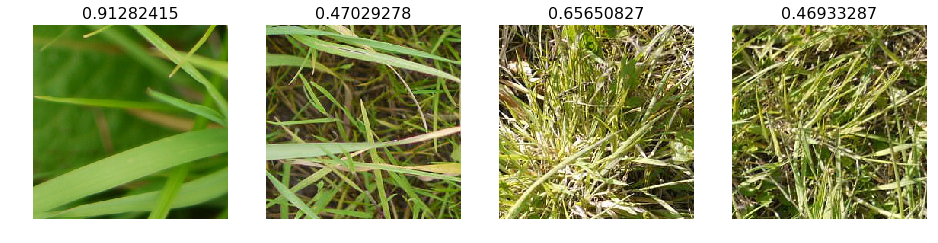

In [34]:
plot_val_with_title(rand_by_correct(False), "A few randomly selected pictures incorrectly classified")

Most correct dock images


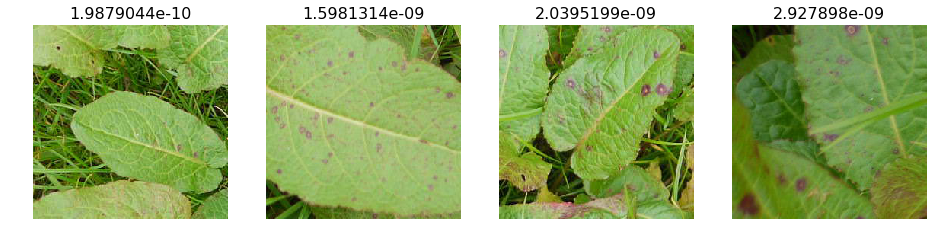

In [35]:
plot_val_with_title(most_by_correct(0, True), "Most correct dock images")

Most correct notdock images (grass or other)


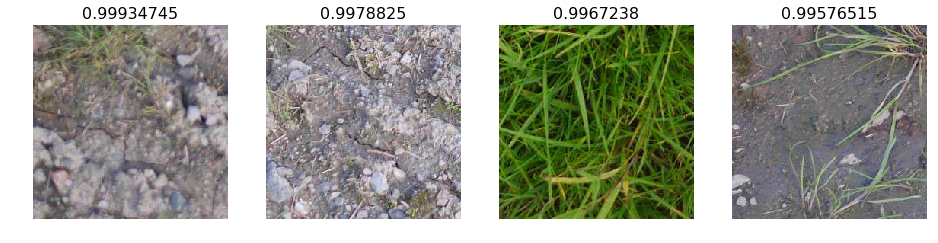

In [36]:
plot_val_with_title(most_by_correct(1, True), "Most correct notdock images (grass or other)")

Most incorrect docks


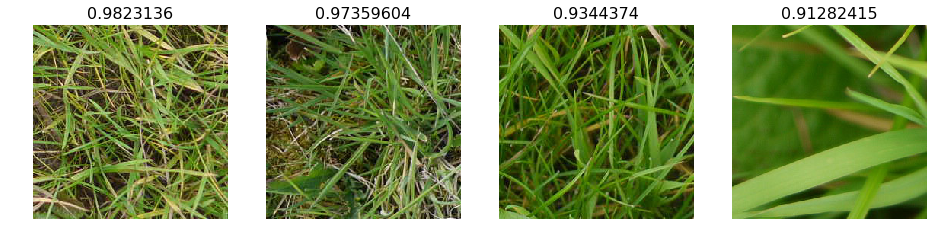

In [37]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect docks")

What we are seeing here is that the docks are often at the edge of the picture, and under difficult lighting conditions. We can possibly remedy these factors through better augementation in the data preprocessing step.

Most incorrect notdocks


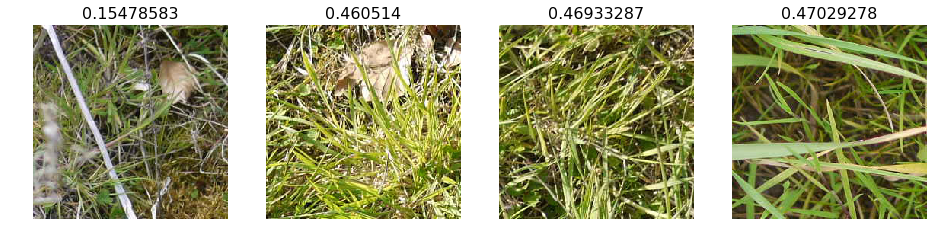

In [38]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect notdocks")

From what we can see here, the algorithm is likely picking up non-dock type plants which are not grass, and assuming they are such things (likely due to the broad leaves).

Most uncertain predictions


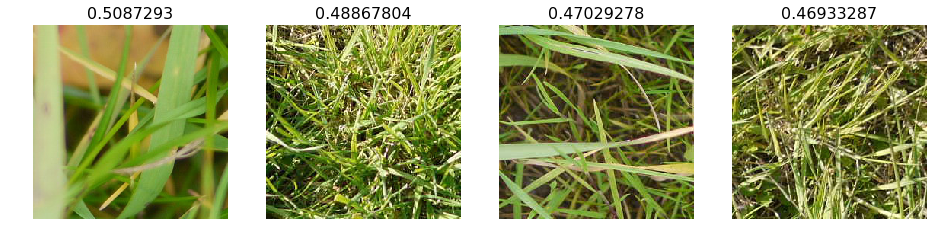

In [39]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

It's possibly lighting, blurriness, and dead leaves, are causing problems for the algorithm.

[[ 73  13]                                   
 [  2 339]]


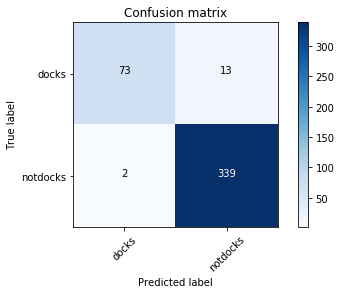

In [40]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
from fastai.plots import plot_confusion_matrix
plot_confusion_matrix(cm, data.classes)

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, probs)

0.9753461092545863

## Discussion

We have taken the direct framework from the first lesson of the Fastai MOOC and applied it here on the Open Sprayer dataset. We first had to balance the training and validation sets, and also understood the class imbalances presented. The accuracy achieved is rather decent for a simple benchmark, concluding with an ROC AUC score of 0.975 (and an accuracy of 96.7%).

Upon qualitatively reviewing the results, we see that data augementation could help us further increase the accuracy of the classifier, via lighting and possibly padding images. Also, we see that a large percentage of docks were predicted to be not docks. This could possibly be remedied by addressing the class imbalance of the dataset.

We will look at both the further data augmentation, and class imbalance aspects in the second part of this series.

## END